# Visualisation of LFP & Calcium traces if no subsessions

### Load LFP and packages

In [1]:
cd "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/"

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023


In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
import json
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
import sys 
import pickle

from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib widget



def filterLFP(lfp, f_lowcut, f_hicut):
    range=f_hicut-f_lowcut
    fs = 1000
    nyq = 0.5 * fs
    N = 3 # Filtre order
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    filt= signal.filtfilt(b, a, lfp)
    # Parameter and computation of CWT
    w = 100. #window size
    freq = np.linspace(f_lowcut, f_hicut, range)
    widths = w*fs / (2*freq*np.pi)
    CWT = signal.cwt(filt, signal.morlet2, widths, w=w)
    # Projection calculation
    absCWT = np.absolute(CWT)
    zabsCWT = stats.zscore(absCWT, axis=None)
    proj_CWT = np.max(zabsCWT, axis = 0)/range
    return proj_CWT


In [3]:
cd "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/minian"


C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian


In [4]:
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    open_minian_mf,
    save_minian,
)

### Choose recording session

In [5]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Select session folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)


In [44]:
folder_base = Path(os.path.join(dpath, "OpenEphys"))

filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
All = np.load(filename2, mmap_mode= 'r')

ScoringFile = folder_base / f'ScoredSleep_AB.npy'
SleepScoredTS=np.load(ScoringFile)

mfile = open(Path(dpath).parent / f'mappingsAB_ALL.pkl', 'rb')
mapping = pickle.load(mfile)
B = mapping['session']    

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
allchannels = pd.read_excel(Channels)

path_obj=Path(folder_base.parent)
if len(path_obj.parts)==10: # Not a DrugExperiment with Subsessions       
    mice= path_obj.parents[1].name
elif len(path_obj.parts)==9: # Not a DrugExperiment with No Subsessions
    mice= path_obj.parents[0].name
elif len(path_obj.parts)==11: # DrugExperiment with Subsessions
    mice = path_obj.parents[2].name

StampsFile = folder_base.parent / f'SynchroFile.xlsx'
Stamps= pd.read_excel(StampsFile)
StartTime = list(Stamps[0])[0]
minian_freq=list(Stamps[0])[2]   

try:
    minian_ds =  open_minian(folder_base.parent /f'V4_Miniscope'/ f'minian')
    subsession=0
except: 
    minian_ds = open_minian_mf(folder_base.parent, ["session"], pattern="minian")
    subsession=1
    
Calcium = minian_ds['C'] # calcium traces 
Spike = minian_ds['S'] # estimated spikes

coord = Calcium.coords['session'].values
loop=coord if subsession else [coord]
freqLFP=1000

AllCalcium=pd.DataFrame()
AllSpike=pd.DataFrame()
for s,subsessionName in enumerate(loop): #number of subsession
    indexMappList=B[subsessionName] if subsession else B[folder_base.parts[-2]]
    folder_mini=folder_base.parent/ f'V4_Miniscope'/subsessionName if subsession else folder_base.parent/ f'V4_Miniscope'
    try:
        TodropFile = folder_mini / f'minian/TodropFileAB.json'
        with open(TodropFile, 'r') as f:
            unit_to_drop = json.load(f)
    except:
        TodropFile = folder_mini / f'minian/TodropFile.json'
        with open(TodropFile, 'r') as f:
            unit_to_drop = json.load(f)
    CalciumSub1 = Calcium[s] if subsession else Calcium
    SpikeSub1 = Spike[s] if subsession else Spike

    AA = CalciumSub1['unit_id']
    copyAA = list(AA.copy())
    for u in unit_to_drop: # ugly way to do it, need to be improved to only use unit_to_drop
        copyAA.remove(u)
    unit_to_keep = copyAA
    Cupd = CalciumSub1.loc[unit_to_keep,:]
    
    nb_unit = Cupd.shape[0]
    units = range(nb_unit)                    
    C_upd_unit_id = Cupd['unit_id'].values
    kept_uniq_unit_List=[]
    for unit in units:
        indexMapp = np.where(indexMappList == C_upd_unit_id[unit])[0]
        kept_uniq_unit_List.append(str(indexMapp))


    CalciumSub = pd.DataFrame(CalciumSub1.loc[unit_to_keep,:], index=[f"{mice}{str(i).replace('[','').replace(']','')}" for i in kept_uniq_unit_List])
    CalciumSub = CalciumSub.dropna(axis=0, how='all') #cause Nans were added to match the different number of units detected per subsessions 
    CalciumSub = CalciumSub.dropna(axis=1, how='all') #cause Nans were added to match the different subsessions video sizes
    SpikeSub = pd.DataFrame(SpikeSub1.loc[unit_to_keep,:], index=[f"{mice}{str(i).replace('[','').replace(']','')}" for i in kept_uniq_unit_List])
    SpikeSub = SpikeSub.dropna(axis=0, how='all') #cause Nans were added to match the different number of units detected per subsessions 
    SpikeSub = SpikeSub.dropna(axis=1, how='all') #cause Nans were added to match the different subsessions video sizes

    print(np.shape(CalciumSub))
    AllCalcium=pd.concat([AllCalcium, CalciumSub.T], axis=0, ignore_index=True) #if CalciumSub.shape[0] else pd.concat([AllCalcium, pd.DataFrame(np.full((1, CalciumSub1.shape[1]), np.nan))], ignore_index=True)
    AllSpike=pd.concat([AllSpike, SpikeSub.T], axis=0, ignore_index=True)# if CalciumSub.shape[0] else pd.concat([AllSpike, pd.DataFrame(np.full((1, CalciumSub1.shape[1]), np.nan))], ignore_index=True)

Calcium=AllCalcium.T
Spike=AllSpike.T

# Delay and Upscale CalciumTraces
nan_matrix=np.full((len(Calcium), int(StartTime*minian_freq)), np.nan) # ISSUES if subsessions
Calcium_aligned=np.concatenate((nan_matrix.T, Calcium.T), axis=0) # ISSUES if subsessions
nan_matrix=np.full((len(Spike), int(StartTime*minian_freq)), np.nan) # ISSUES if subsessions
Spike_aligned=np.concatenate((nan_matrix.T, Spike.T), axis=0) # ISSUES if subsessions

scalefactor=freqLFP/minian_freq
upscaled_Calcium = np.repeat(Calcium_aligned, scalefactor, axis=0) # ISSUES if subsessions
upscaled_Spike = np.repeat(Spike_aligned, scalefactor, axis=0) # ISSUES if subsessions

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
EMGch1=int(allchannels[mice][3])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 
S1  =  All[:, S1ch1]-All[:, S1ch2] 
EMG  =  All[:, EMGch1]

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS) - 1, len(SleepScoredTS))
new_indices = np.linspace(0, len(SleepScoredTS) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS, kind='zero')
SleepScoredTS_upscaled = interpolated_func(new_indices)
SleepScoredTS_upscaled = np.round(SleepScoredTS_upscaled * 2) / 2

(20, 17911)


### Load detected oscillations

In [45]:
OldSWSdetection=folder_base / f'SWRproperties_8sd_AB.xlsx'
SWR_prop = pd.read_excel(OldSWSdetection, index_col=0)            
OldSWSdetection=folder_base / f'SWRproperties.csv'
SWR_prop = pd.read_csv(OldSWSdetection, index_col=0)         
try: 
    SWR_prop['toKeep'] = SWR_prop['toKeep'].astype(str)
    SWR_prop  = SWR_prop[SWR_prop['toKeep'].isin(['VRAI', 'True'])]        
except: None
SWR_peak = np.transpose(SWR_prop['peak time'].astype(int))
SWR_start = np.transpose(SWR_prop['start time'].astype(int))
SWR_end = np.transpose(SWR_prop['end time'].astype(int))

OldS1spdldetection=folder_base / f'Spindlesproperties_S1_7sd_AB.xlsx'
S1spdl_prop = pd.read_excel(OldS1spdldetection, index_col=0)            
OldS1spdldetection=folder_base / f'Spindleproperties_S1&PFC.csv'
S1spdl_prop = pd.read_csv(OldS1spdldetection, index_col=0)  
S1spdl_prop['toKeep'] = S1spdl_prop['toKeep'].astype(str)
S1spdl_prop  = S1spdl_prop[S1spdl_prop['toKeep'].isin(['VRAI', 'True'])]
S1spdl_peak = np.transpose(S1spdl_prop['peak time'].astype(int))
S1spdl_start = np.transpose(S1spdl_prop['start time'].astype(int))
S1spdl_end = np.transpose(S1spdl_prop['end time'].astype(int))

OldPFCspdldetection=folder_base / f'Spindlesproperties_PFC_7sd_AB.xlsx'
PFCspdl_prop = pd.read_excel(OldPFCspdldetection, index_col=0)            
OldPFCspdldetection=folder_base / f'Spindleproperties_S1&PFC.csv'
PFCspdl_prop = pd.read_csv(OldPFCspdldetection, index_col=0)  
PFCspdl_prop['toKeep'] = PFCspdl_prop['toKeep'].astype(str)
PFCspdl_prop  = PFCspdl_prop[PFCspdl_prop['toKeep'].isin(['VRAI', 'True'])]       
PFCspdl_peak = np.transpose(PFCspdl_prop['peak time'].astype(int))
PFCspdl_start = np.transpose(PFCspdl_prop['start time'].astype(int))
PFCspdl_end = np.transpose(PFCspdl_prop['end time'].astype(int))


### EphyViewer = LFPs, Calcium traces, Spikes

In [46]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource
from ephyviewer import InMemorySpikeSource


app = mkQApp()
win = MainViewer(debug=True, show_auto_scale=True)

# LFPs

sample_rate = freqLFP
t_start = 0.
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}
combined = np.stack([(S1)/2, (PFC)*3, (CA1)/5, (EMG)/2], axis = 1)
#source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])
source =InMemoryAnalogSignalSource(combined, sample_rate, t_start, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])
view1 = TraceViewer(source=source)

view1.params['display_labels'] = True
view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

# Calcium traces 
view2 = TraceViewer.from_numpy(zscore(np.array(Calcium.T), nan_policy='omit'), float(minian_freq), round(StartTime,2), 'Calcium Traces',channel_names=Calcium.index)
view2.params['scale_mode'] = 'same_for_all'
view2.auto_scale()
view2.params['display_labels'] = True


# Spike traces 

all_spikes = []
for c,row in enumerate(upscaled_Spike.T):
    peaks, _ = find_peaks(row)#, height=np.nanstd(row)/5)
    all_spikes.append({ 'time':peaks/freqLFP, 'name':Calcium.index[c] })
source = InMemorySpikeSource(all_spikes=all_spikes)
view3 = ephyviewer.SpikeTrainViewer(source=source, name='spikes')


# Sleep Scoring

array=SleepScoredTS_upscaled
SleepScoredTS_upscaled[SleepScoredTS_upscaled == 0.5] = 0
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'NREM', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view4= EpochViewer(source=source_ep, name='Scoring')

view4.by_channel_params['ch0', 'color'] = '#5555FF'
view4.by_channel_params['ch1', 'color'] = '#00AA00'
view4.by_channel_params['ch2', 'color'] = '#FFFFFF'
#add them to mainwindow

win.add_view(view1)
win.add_view(view4)
win.add_view(view2)
win.add_view(view3)

#Run

win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.001224517822265625 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refr

0

### EphyViewer =  LFPs, Spikes, FFT

In [47]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource
from ephyviewer import InMemorySpikeSource

app = mkQApp()
win = MainViewer(debug=True, show_auto_scale=True)

# LFPs

sample_rate = freqLFP
t_start = 0.
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}
combined = np.stack([(S1), (PFC), (CA1)/5, (EMG)/5], axis = 1)
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

view1 = TraceViewer(source=source)

view1.params['display_labels'] = True
view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

# FFT
view3 = TimeFreqViewer(source=source, name='FFT')

view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 60
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz

view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch1', 'clim'] = 300
view3.by_channel_params['ch2', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True
view3.by_channel_params['ch1', 'visible'] = False
view3.by_channel_params['ch2', 'visible'] = False
view3.by_channel_params['ch3', 'visible'] = False


# Spike traces 

all_spikes = []
for c,row in enumerate(upscaled_Spike.T):
    peaks, _ = find_peaks(row)#, height=np.nanstd(row))
    all_spikes.append({ 'time':peaks/freqLFP, 'name':Calcium.index[c] })
source = InMemorySpikeSource(all_spikes=all_spikes)
view2 = ephyviewer.SpikeTrainViewer(source=source, name='spikes')


# Add them to mainwindow

win.add_view(view1)
win.add_view(view2)
win.add_view(view3)

#Run

win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for spikes 0.0 s
refresh duration for  0.0 s
refresh duration for spikes 0.0 s
refresh duration for FFT 0.0 s
save_all_settings


0

### Save Extract of Raw Data

In [42]:
from scipy.stats import zscore

beg=int(StartTime)+1
end=int(StartTime+(len(upscaled_Calcium)/freqLFP))

proj_ThetaCWT=filterLFP(CA1,5,9)
proj_Beta1CWT=filterLFP(PFC,10,18)
proj_Beta2CWT=filterLFP(S1,10,18)
proj_DeltaCWT=filterLFP(S1,1,4)

S1extract=(S1[beg*sample_rate:end*sample_rate])
BetaS1extract=(proj_Beta2CWT[beg*sample_rate:end*sample_rate])
DeltaCWTextract=(proj_DeltaCWT[beg*sample_rate:end*sample_rate])
PFCextract=(PFC[beg*sample_rate:end*sample_rate])
BetaPFCextract=(proj_Beta1CWT[beg*sample_rate:end*sample_rate])
CA1extract=(CA1[beg*sample_rate:end*sample_rate])
Thetaextract=(proj_ThetaCWT[beg*sample_rate:end*sample_rate])
EMGextract=(EMG[beg*sample_rate:end*sample_rate])
HypnoExtract=SleepScoredTS_upscaled[beg*sample_rate:end*sample_rate]

S1extractDS=S1extract[::100]
BetaS1extractDS=BetaS1extract[::100]
DeltaCWTextractDS=DeltaCWTextract[::100]
PFCextractDS=PFCextract[::100]
BetaPFCextractDS=BetaPFCextract[::100]
CA1extractDS=CA1extract[::100]
ThetaextractDS=Thetaextract[::100]
EMGextractDS=EMGextract[::100]
HypnoExtractDS=HypnoExtract[::100]

Extract=pd.DataFrame({'S1': S1extract,'filtS1': BetaS1extract,  'PFC': PFCextract, 'filtPFC': BetaPFCextract, 'CA1':CA1extract,'filtCA1': Thetaextract,  'EMG':EMGextract, 'Hypno': HypnoExtract})
ExtractDS=pd.DataFrame({'S1': S1extractDS, 'filtS1': BetaS1extractDS, 'filtDelta': DeltaCWTextractDS, 'PFC': PFCextractDS, 'filtPFC': BetaPFCextractDS, 'CA1':CA1extractDS,'filtCA1': ThetaextractDS,  'EMG':EMGextractDS, 'Hypno': HypnoExtractDS})

CaExtract=zscore(upscaled_Calcium[beg*sample_rate:end*sample_rate])
CaExtractDS=CaExtract[::100]

UnitName=[f'Unit #{i}' for i in range(len(Calcium))]
Ca=pd.DataFrame(CaExtract, columns=UnitName)
CaDSo=pd.DataFrame(CaExtractDS, columns=Calcium.index)
CaDS = CaDSo*2 + [10 * i for i in range(1, len(CaDSo.columns) + 1)]

Sum=pd.concat([Extract,Ca], axis=1)
SumDS=pd.concat([ExtractDS,CaDS], axis=1)


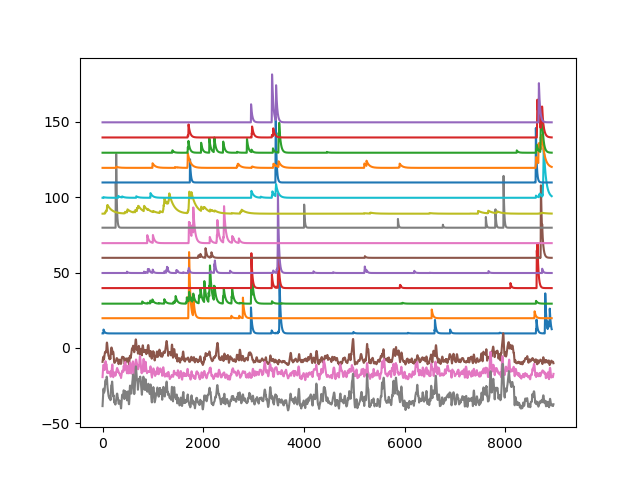

In [43]:
# Create a figure
plt.close()
plt.plot(CaDS)
plt.plot(BetaS1extractDS*20-10)
plt.plot(BetaPFCextractDS*20-20)
plt.plot((BetaPFCextractDS+BetaS1extractDS)*20-40)
#print('r=', round(np.corrcoef(c,BetaPFCextractDS )[0,1], 2))
plt.show()


In [ ]:
filenameOut=f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{beg}to{end}s.xlsx'
writer=pd.ExcelWriter(filenameOut)
SumDS.to_excel(writer, sheet_name='All')
HypnoExtractDS=pd.DataFrame(HypnoExtractDS[::10])
HypnoExtractDS.to_excel(writer, sheet_name='DownSample10times')
writer.close()

In [ ]:
# Save the figure as a .png file
filenameOut=f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{beg}to{end}s.png'
plt.savefig(filenameOut, format='png', dpi=300)